In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

In [2]:
#ee.Authenticate()
#geemap.update_package()

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

##Adding every plot coordinate
allplots_ga = 'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/GA_allplots_NEW.csv'
allplots_va= pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Coordinates and biomass/va_allpoints.csv')
allplots_va = allplots_va[allplots_va['liveMass'].notna()]
allplots_va = allplots_va[allplots_va['Latitude'].notna()]
allplots_va = allplots_va.drop(columns = ['deadMass', 'collectDate', 'totalMass', 'Ell', 'MSL', 'latitude', 'longitude'])
df_temp=allplots_va.copy()
df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size]
    }
)
df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N'
]
allplots_va = df_temp
s_patens = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Massachusetts/LTE-MP-LPP-biomass.csv')
s_alterniflora = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Massachusetts/LTE-MP-LPA-biomass.csv')
s_patens['Latitude'] = 42.730953216553
s_patens['Longitude'] = -70.842918395996
s_alterniflora['Latitude'] = 42.731742858887
s_alterniflora['Longitude'] = -70.842468261719
s_patens.rename(columns={'LIVE biomass':'liveMass'}, inplace=True)
s_alterniflora.rename(columns={'MEAN BIOMASS':'liveMass'}, inplace=True)
df = pd.concat([s_patens, s_alterniflora])
df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
dfx =  df.groupby(['SITE', 'Date'], as_index = False).aggregate(
    {
        'Longitude':[np.mean], 'Latitude':[np.mean], 'liveMass':[np.mean, np.size], 
        'MONTH':'first', 'YEAR':'first'
    }
) 
dfx.columns = [
    'Site','Date','Longitude','Latitude','liveMass', 'Sample size','Month', 'Year'
]

dfx.loc[dfx['Site'] == 'LTE-MP-LPP', 'Latitude'] = 42.730953216553
dfx.loc[dfx['Site'] == 'LTE-MP-LPP', 'Longitude'] = -70.842918395996
dfx.loc[dfx['Site'] == 'LTE-MP-LPA', 'Latitude'] = 42.731742858887
dfx.loc[dfx['Site'] == 'LTE-MP-LPA', 'Longitude'] = -70.842468261719

fc_ma = geemap.pandas_to_ee(dfx, latitude = 'Latitude', longitude = 'Longitude')
fc_va = geemap.pandas_to_ee(allplots_va, latitude = "Latitude", longitude = "Longitude")
fc_ga = geemap.csv_to_ee(allplots_ga, latitude = "Latitude", longitude = "Longitude")

Map.addLayer(fc_ma, {}, "MA")
Map.addLayer(fc_va, {}, "VA")
Map.addLayer(fc_ga, {}, "GA")

# Map

In [3]:
yr_start = 2021
yr_end = 2021

ls_ma = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_ma) \
    .filter(ee.Filter.calendarRange(yr_start, yr_end,'year'))

ls_va = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_va) \
    .filter(ee.Filter.calendarRange(yr_start, yr_end,'year'))

ls_ga = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_ga) \
    .filter(ee.Filter.calendarRange(yr_start, yr_end,'year'))

In [12]:
# Apply scaling factors, cloud mask, and FLATS
def addFLATS(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(flats.rename('flats'))

def maskFLATS(image):
    mask1 = image.select('flats').lte(0.1) #less than or equal to 0.1 - change?
    return image.updateMask(mask1)

def addpheno(image):
    pheno = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addndvi(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addevi(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(evi.rename('evi'))

def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

scaled_ma = ls_ma.map(maskL8sr).map(addFLATS).map(maskFLATS).map(addpheno).map(addndvi).map(addevi).map(addnirv)
scaled_va = ls_va.map(maskL8sr).map(addFLATS).map(maskFLATS).map(addpheno).map(addndvi).map(addevi).map(addnirv)
scaled_ga = ls_ga.map(maskL8sr).map(addFLATS).map(maskFLATS).map(addpheno).map(addndvi).map(addevi).map(addnirv)

In [13]:
#https://developers.google.com/earth-engine/apidocs/ee-imagecollection-getregion

#alternatively, ee.image sample? https://developers.google.com/earth-engine/api_docs#ee.image.sample

In [ ]:
#LTER domains:
gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simple.shp' ##Simplified GCE domain - reduced number of vertices
vcr_clip = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simple.shp' ##Simplified VCR domain - reduced number of vertices
pie_clip = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simple.shp' ##Simplified PIE domain - reduced number of vertices

gaclip1 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip1.shp'
gaclip2 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip2.shp'
gaclip3 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip3.shp'
gaclip4 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip4.shp'
gaclip5 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip5.shp'
gaclip6 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip6.shp'
gaclip7 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip7.shp'
gaclip8 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip8.shp'
gaclip9 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip9.shp'
gaclip10 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip10.shp'
gaclip11 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip11.shp'
gaclip12 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/gaclip12.shp'

wet_ga = geemap.shp_to_ee(gce_clip)

wet_ga1 = geemap.shp_to_ee(gaclip1)
wet_ga2 = geemap.shp_to_ee(gaclip2)
wet_ga3 = geemap.shp_to_ee(gaclip3)
wet_ga4 = geemap.shp_to_ee(gaclip4)
wet_ga5 = geemap.shp_to_ee(gaclip5)
wet_ga6 = geemap.shp_to_ee(gaclip6)
wet_ga7 = geemap.shp_to_ee(gaclip7)
wet_ga8 = geemap.shp_to_ee(gaclip8)
wet_ga9 = geemap.shp_to_ee(gaclip9)
wet_ga10 = geemap.shp_to_ee(gaclip10)
wet_ga11 = geemap.shp_to_ee(gaclip11)
wet_ga12 = geemap.shp_to_ee(gaclip12)

# ga_estuaries = ee.Geometry.MultiPolygon([
#     wet_ga1, wet_ga2, wet_ga3, wet_ga4, wet_ga5, wet_ga6, wet_ga7, wet_ga8, wet_ga9, wet_ga10, wet_ga11, wet_ga12
# ])

wet_va = geemap.shp_to_ee(vcr_clip)
wet_ma = geemap.shp_to_ee(pie_clip)
joinedFeatures = wet_ga.union()

# clip_ga = scaled_ga.map(lambda image: image.clip(wet_ga))
# clip_0 = ee.Image(clip_ga.toList(clip_ga.size()).get(1)) ##Second image in collection

# Map.addLayer(clip_0, l8_param, 'Landsat 2020')
# Map.addLayer(ee.Image(scaled_ga.toList(scaled_ga.size()).get(0)), l8_param, '2020 Landsat 8 collection')
Map.addLayer(gce_clip, {}, 'GA estuaries')

Map

In [ ]:
#Time series of pheno band

#Add NIRV index! NIR*ndvi

out_dir = os.path.expanduser('~/Downloads')

out_ga = os.path.join(out_dir, 'nirv_ga21.csv')
out_va = os.path.join(out_dir, 'nirv_va21.csv')
out_ma = os.path.join(out_dir, 'nirv_ma21.csv')

collection_ga = scaled_ga \
                  .select("nirv")

collection_va = scaled_va \
                  .select("nirv")

collection_ma = scaled_ma \
                  .select("nirv")

# geemap.zonal_statistics(in_value_raster = collection_ga, in_zone_vector = wet_ga, \
#                 out_file_path = out_ga, statistics_type='MEAN', \
#                 scale = 30)

# geemap.zonal_statistics(in_value_raster = collection_va, in_zone_vector = wet_va, \
#                 out_file_path = out_va, statistics_type='MEAN', \
#                 scale = 30)

# geemap.zonal_statistics(in_value_raster = collection_ma, in_zone_vector = wet_ma, \
#                 out_file_path = out_ma, statistics_type='MEAN', \
#                 scale = 30)

In [20]:
#Read files, create time series
import glob
pathga = r'C:/Users/arj26323/Documents/Data/Phenology/EVI/GA'
pathva = r'C:/Users/arj26323/Documents/Data/Phenology/EVI/VA' 
pathma = r'C:/Users/arj26323/Documents/Data/Phenology/EVI/MA'

all_files = glob.glob(pathga + "/*.csv")

li = []

for filename in all_files:
    df_ga = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_ga)

df_ga = pd.concat(li, axis=1, ignore_index=False)

df_ga

all_files = glob.glob(pathva + "/*.csv")

li = []

for filename in all_files:
    df_va = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_va)

df_va = pd.concat(li, axis=1, ignore_index=False)

df_va

all_files = glob.glob(pathma + "/*.csv")

li = []

for filename in all_files:
    df_ma = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_ma)

df_ma = pd.concat(li, axis=1, ignore_index=False)

# df_ma

In [21]:
#Feesh
for col in df_ga.columns:
    print(col)

LC08_016038_20130328_evi
LC08_016038_20130412_evi
LC08_016038_20130428_evi
LC08_016038_20130514_evi
LC08_016038_20130530_evi
LC08_016038_20130615_evi
LC08_016038_20130701_evi
LC08_016038_20130717_evi
LC08_016038_20130802_evi
LC08_016038_20130818_evi
LC08_016038_20130903_evi
LC08_016038_20130919_evi
LC08_016038_20131005_evi
LC08_016038_20131021_evi
LC08_016038_20131106_evi
LC08_016038_20131122_evi
LC08_016038_20131224_evi
LC08_016039_20130701_evi
LC08_016039_20130717_evi
LC08_016039_20130802_evi
LC08_016039_20130818_evi
LC08_016039_20130903_evi
LC08_016039_20130919_evi
LC08_016039_20131005_evi
LC08_016039_20131021_evi
LC08_016039_20131106_evi
LC08_016039_20131122_evi
LC08_016039_20131208_evi
LC08_016039_20131224_evi
LC08_017038_20130622_evi
LC08_017038_20130708_evi
LC08_017038_20130724_evi
LC08_017038_20130809_evi
LC08_017038_20130825_evi
LC08_017038_20130910_evi
LC08_017038_20131012_evi
LC08_017038_20131028_evi
LC08_017038_20131113_evi
LC08_017038_20131129_evi
LC08_017038_20131231_evi


In [22]:
import datetime
dates_ga = df_ga.filter(regex='016038') ##Based on Landsat 8 image collection prefix! With GA, only getting one scene
dates_ga.columns = pd.to_datetime(dates_ga.columns.str.split('_').str[2])
dates_ga

dates_va = df_va.filter(regex='LC') ##Based on Landsat 8 image collection prefix!
dates_va.columns = pd.to_datetime(dates_va.columns.str.split('_').str[2])
dates_va

dates_ma = df_ma.filter(regex='LC') ##Based on Landsat 8 image collection prefix!
dates_ma.columns = pd.to_datetime(dates_ma.columns.str.split('_').str[2])
dates_ma

,2013-04-04,2013-04-09,2013-04-16,2013-05-02,2013-05-18,2013-06-03,2013-06-19,2013-07-05,2013-07-21,2013-08-06,...,2021-07-11,2021-07-27,2021-08-12,2021-08-28,2021-09-13,2021-09-29,2021-10-15,2021-10-31,2021-11-16,2021-12-18
0,0.022843,0.027436,NaN,NaN,0.040721,NaN,0.141258,0.153812,NaN,0.151442,...,NaN,0.131336,0.116722,NaN,0.094455,NaN,NaN,NaN,NaN,NaN
1,0.017739,0.022046,0.017554,NaN,0.032077,NaN,0.114134,0.126057,NaN,0.110485,...,NaN,0.148187,0.115300,NaN,0.093073,NaN,NaN,NaN,0.071266,NaN
2,0.022114,0.024041,0.030005,NaN,0.030671,NaN,0.117991,0.113103,NaN,0.117655,...,NaN,0.162461,0.107138,NaN,0.084959,NaN,NaN,NaN,NaN,NaN
3,0.029212,0.032951,0.023553,NaN,0.039110,NaN,0.080175,0.090173,NaN,0.089218,...,NaN,0.094530,0.090893,NaN,0.076274,NaN,NaN,NaN,0.038085,NaN
4,0.060693,NaN,0.060959,0.051488,0.062170,NaN,0.096162,0.102991,NaN,0.092456,...,NaN,0.095177,0.100489,NaN,0.072161,NaN,NaN,NaN,0.023584,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,0.026236,NaN,0.030805,0.019801,0.034112,NaN,0.041435,NaN,NaN,0.107804,...,NaN,0.065286,0.061406,NaN,0.050862,0.050001,NaN,NaN,0.014274,NaN
592,0.030387,0.031729,0.029908,0.027396,0.030819,NaN,0.053940,0.079063,NaN,0.088116,...,0.084827,0.054836,0.069506,NaN,0.043871,NaN,NaN,NaN,0.029493,NaN
593,0.038680,0.031744,0.038231,0.033853,0.034474,NaN,0.062210,0.093121,NaN,0.113140,...,0.097032,0.075225,0.080860,NaN,0.052936,NaN,NaN,NaN,0.023004,NaN
594,0.041337,0.043303,0.039659,0.039723,0.042454,NaN,0.067623,0.077991,NaN,0.075039,...,0.081251,0.082170,0.090942,NaN,0.055606,NaN,NaN,NaN,0.042217,NaN


In [23]:
mean_ma = dates_ma.mean()
mean_va = dates_va.mean()
mean_ga = dates_ga.mean()

ga = pd.DataFrame(mean_ga, index = None, columns = ['EVI'])
ga['Date'] = ga.index
ga['LTER'] = 'GCE'

va = pd.DataFrame(mean_ma, index = None, columns = ['EVI'])
va['Date'] = va.index
va['LTER'] = 'VCR'

ma = pd.DataFrame(mean_va, index = None, columns = ['EVI'])
ma['Date'] = ma.index
ma['LTER'] = 'PIE'

ga

df2 = pd.concat([ma, va, ga], axis = 0)

df2

,EVI,Date,LTER
2013-03-20,0.028124,2013-03-20,PIE
2013-04-14,0.036617,2013-04-14,PIE
2013-05-16,0.052683,2013-05-16,PIE
2013-06-01,0.055523,2013-06-01,PIE
2013-06-17,NaN,2013-06-17,PIE
...,...,...,...
2021-10-27,0.069810,2021-10-27,GCE
2021-11-12,0.060541,2021-11-12,GCE
2021-11-28,NaN,2021-11-28,GCE
2021-12-14,0.068794,2021-12-14,GCE


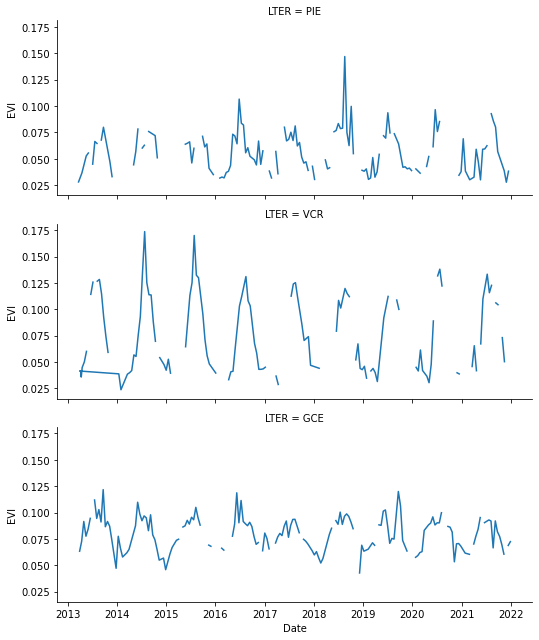

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

start_date = '2013-1-1'
end_date = '2021-12-31'

x1 = df2[(df2['Date'] > start_date) & (df2['Date'] <= end_date)]

dims = (11.7, 8.27)
# fig, ax = plt.subplots(figsize=dims)
# g = sns.lineplot(ax = ax, x = "Date", y = "NIRv_av", hue = 'LTER', data = x1)

g =  sns.FacetGrid(x1,col='LTER',col_wrap=1, aspect=2.5)
g.map_dataframe(plt.plot,'Date','EVI')

plt.show(g)

##Something very strange in Virginia in 2018 - Winter

#DAY OF GREENUP:
#2013: GCE: VCR: PIE:

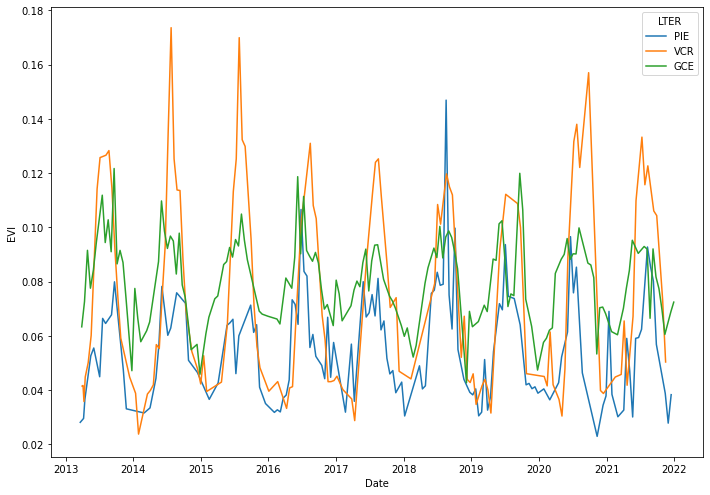

In [25]:
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
g = sns.lineplot(ax = ax, x = "Date", y = "EVI", hue = 'LTER', data = x1)

,mean,sem,EVI,Month,LTER
Date,,,,,
1,0.066600,0.002586,0.066600,Jan,GCE
2,0.061359,0.001694,0.061359,Feb,GCE
3,0.066884,0.002063,0.066884,Mar,GCE
4,0.079274,0.002092,0.079274,Apr,GCE
5,0.086653,0.001531,0.086653,May,GCE
6,0.094669,0.002555,0.094669,Jun,GCE
7,0.093403,0.002374,0.093403,Jul,GCE
8,0.090041,0.002816,0.090041,Aug,GCE
9,0.093665,0.003475,0.093665,Sep,GCE


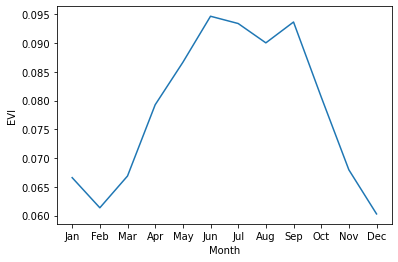

In [26]:
import calendar
gax = ga.groupby([ga.Date.dt.month])['EVI'].agg(['mean', 'sem'])
gax['EVI'] = gax['mean']
gax['Month'] = gax.index
gax['Month'] = gax['Month'].apply(lambda x: calendar.month_abbr[x])
gax['LTER'] = 'GCE'

sns.lineplot(x = "Month", y = "EVI", data = gax)
gax

<AxesSubplot:xlabel='Month', ylabel='EVI'>

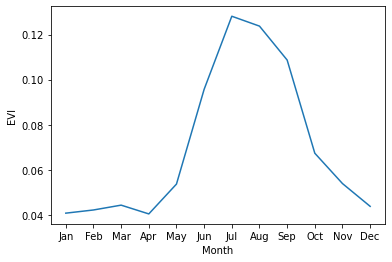

In [27]:
vax = va.groupby([va.Date.dt.month])['EVI'].agg(['mean', 'sem'])
vax['EVI'] = vax['mean']
vax['Month'] = vax.index
vax['Month'] = vax['Month'].apply(lambda x: calendar.month_abbr[x])
vax['LTER'] = 'VCR'

sns.lineplot(x = "Month", y = "EVI", data = vax)

<AxesSubplot:xlabel='Month', ylabel='EVI'>

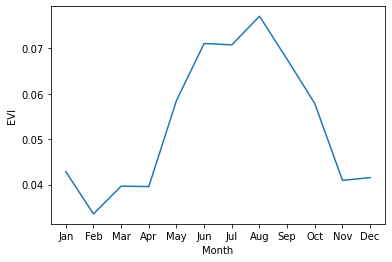

In [28]:
ma2 = ma.groupby([ma.Date.dt.month])['EVI'].agg(['mean', 'sem'])
ma2['EVI'] = ma2['mean']
ma2['Month'] = ma2.index
ma2['Month'] = ma2['Month'].apply(lambda x: calendar.month_abbr[x])
ma2['LTER'] = 'PIE'


sns.lineplot(x = "Month", y = "EVI", data = ma2)

In [ ]:
df3 = pd.concat([gax, vax, ma2])
df3

g = sns.FacetGrid(data=df3, col='LTER', aspect=1.5)
g.map(sns.lineplot(x ='Month', y = 'NIRv_av'))


In [ ]:
df3